### Group NULL
#### Bryson Adcock, Brooke Arnold, Sam Bornstein, Paul Sirena

# Star Wars Action Figure Analysis

The Star Wars universe has arguably the most detail of any universe in movie history. Each character has a name and backstory regardless of what their role is in the story.

To add to this detail, just about every character has been made into an action figure. Star Wars is well known for revolutionizing the toy industry, mainly with their 3.75” linesoriginally made by Kenner and later Hasbro.

We will be investigating data on every 3.75” action figure ever made and seeing what trends we can find from the character, species, and planet data.

### Data Collection

Our data comes from two main sources. For characters, species, and planets, we have data from Kaggle that originally came from the Star Wars API. This was available on the Star Wars Wiki and is no longer available. For data on action figures, the master list from jedibusiness.com was used. Here are links to all four datasets:
- https://www.kaggle.com/jsphyg/star-wars?select=characters.csv
- https://www.kaggle.com/jsphyg/star-wars?select=planets.csv
- https://www.kaggle.com/jsphyg/star-wars?select=species.csv
- https://jedibusiness.com/MasterList

We also created our own dataset to supplement our information on each character from Kaggle.  We felt this information would be necessary to understand whether a character was made into an action figure. With only 87 characters in the Kaggle Dataset, this was not too difficult to gather ourselves.  The dataset includes the columns:
- Jedi: whether the character is a Jedi
- Sith: whether the character is a Sith
- Hero: whether the character is a Hero (member of Galactic Republic, Rebels, Resistance, etc.)
- Villain: whether the character is a Villain (member of Empire, Separatists, First Order, etc.)
- BountyHunter: whether the character is a bounty hunter
- Neutral: whether the character is neutral to the story conflict
- OriginalTril: whether the character appeared in the Original Trilogy (Episodes 4, 5, and 6)
- PrequelTril: whether the character appeared in the Prequel Trilogy (Episodes 1, 2, and 3)
- SequelTril: whether the character appeared in the Sequel Trilogy (Episodes 7, 8, and 9)
- Movies: the number of movies the character appeared in

## Research Questions

1. Who are the most frequently produced characters?
2. What are the most popular characteristics of action figures?
3. How do the toylines differ from one another?
4. Can we predict how many figures will be made of a character?

### Data Cleaning
We first read in all of our datasets from our various locations.

In [1]:
import pandas as pd
from ipywidgets import widgets, interactive, Layout
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
# Read csv containing information from Kaggle dataset
characters = pd.read_csv("data/characters.csv")
planets = pd.read_csv("data/planets.csv")
species = pd.read_csv("data/species.csv")

# Read csv containing extra information on characters that we felt would be helpful
characters_extra = pd.read_csv("data/characters_extra_info.csv")

# Read csv containing action figure data from jedibusiness.com/MasterList
actionFigures = pd.read_csv("data/JediBusinessFigures.csv")

First, we cleaned `actionFigures` by removing unnecessary columns, filling missing values and changing the datatype of the column `Year`.  We also edited the name of one the action figures so that it matched the name of all the other action figures of the character.

In [3]:
# This column became irrelevant because we only wanted to look at the 3.75" figures so having the column is unnecessary.
actionFigures = actionFigures.drop(['Size'],axis=1)
actionFigures

# Assign 2018 to year for the missing value in the year column for a figure from the SOLO: A Star
#  Wars Story toyline. This was the only missing value in the column.
actionFigures.Year = actionFigures.Year.fillna(2018)

# Cast Year to integer datatype
actionFigures.Year = actionFigures.Year.astype(int)

# Only one figure of Emperor Palpatine had the word Emperor in the name. The rest all had just 
#  'Palpatine (Darth Sidious)', so we changed this value so it was not left out despite being 
#  the same character.
actionFigures['Name'].replace({'Emperor Palpatine (Darth Sidious)':'Palpatine (Darth Sidious)'}, inplace = True)

Next, we handled several issues with `characters`. We filled missing values in the categorical columns with new categories, altered some names to ensure they will not be missed when joining in action figure data, and changed the datatype of the mass column. We also added new columns of information from the file `characters_extra_info.csv` which we created to add extra information that was not in our dataset but we felt would be a good supplement to the information we had.

In [4]:
# Assign values to missing data after checking what rows had data missing
# (i.e. droids with NaN gender or hair_color were changed to none)
characters.homeworld = characters.homeworld.fillna('Unknown')
characters.species = characters.species.fillna('Unknown')
characters.birth_year = characters.birth_year.fillna('Unknown')
characters.eye_color = characters.eye_color.fillna('Unknown')
characters.skin_color = characters.skin_color.fillna('Unknown')
characters.gender = characters.gender.fillna('none')
characters.hair_color = characters.hair_color.fillna('none')

# Change the datatype of the character's mass to a float rather than a string.
characters.mass = characters.mass.astype('float')

# Join in the new information we gathered to supplement our information on each character.
characters_full = characters.join(characters_extra.set_index("name"), on = 'name')

# Used to normalize different variations of a characters name between the
#  characters data and action figure data.
characters_full["name"].replace({"Leia Organa": "Princess Leia Organa", 
                                 "Grievous": "General Grievous",
                                 "Palpatine": "Palpatine (Darth Sidious)",
                                 "Beru Whitesun lars":"Beru Whitesun",
                                 "Wilhuff Tarkin":"Grand Moff Tarkin",
                                 "Jabba Desilijic Tiure":"Jabba The Hutt",
                                 "Jek Tono Porkins":"Jek Porkins",
                                 "Ackbar":"Admiral Ackbar",
                                 "Wicket Systri Warrick":"Wicket",
                                 "Roos Tarpals":"Captain Tarpals",
                                 "Rugor Nass":"Boss Nass",
                                 "Ric Olié":"Ric Olie",
                                 "Quarsh Panaka":"Captain Panaka",
                                 "Ayla Secura":"Aayla Secura",
                                 "Ki-Adi-Mundi":"Ki-Adi Mundi",
                                 "Gregar Typho":"Captain Typho",
                                 "Poggle the Lesser":"Poggle The Lesser",
                                 "Dooku":"Count Dooku",
                                 "Bail Prestor Organa":"Bail Organa",
                                 "BB8":"BB-8"}, inplace=True)

Finally, we joined all our datasets so all the characters information is attached to its respective action figures.  We also saved the dataset to a new file `all_data.csv` and our updated characters dataset with our new data added to a file `characters_updated.csv`.

In [5]:
# Join character information to figures dataset on an inner join so that each figure can have all information about the 
#  character. Inner join to only keep matches
figCharJoin = actionFigures.join(characters_full.set_index("name"), on = 'Name', how='inner', lsuffix='_fig', rsuffix='_char')

# Add home planet information for figure character pairs.
figCharHWJoin = figCharJoin.join(planets.set_index("name"), on = 'homeworld', how='left', rsuffix='_homeworld')

# Add species information for matched character to figure pairs
all_data_df = figCharHWJoin.join(species.set_index("name"), on = 'species', how='left', rsuffix='_species')

# Reset the index
all_data_df = all_data_df.reset_index().drop(columns=['index'])

In [6]:
# Saved our new joined dataframe to its own csv file
all_data_df.to_csv("data/all_data.csv",index=False)

# Saved our characters dataset with the new information into its own csv file
characters_full.to_csv("data/characters_updated.csv",index=False)

### Data Info

In [7]:
all_data_df.columns
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1446 entries, 0 to 1445
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               1446 non-null   object 
 1   Title              1422 non-null   object 
 2   Year               1446 non-null   int64  
 3   Toyline            1446 non-null   object 
 4   Brand              1446 non-null   object 
 5   height             1367 non-null   float64
 6   mass               1313 non-null   float64
 7   hair_color         1446 non-null   object 
 8   skin_color         1446 non-null   object 
 9   eye_color          1446 non-null   object 
 10  birth_year         1446 non-null   object 
 11  gender             1446 non-null   object 
 12  homeworld          1446 non-null   object 
 13  species            1446 non-null   object 
 14  Jedi               1446 non-null   int64  
 15  Sith               1446 non-null   int64  
 16  Hero               1446 

#### Variable distributions

<AxesSubplot:title={'center':'Height Histogram'}, ylabel='Frequency'>

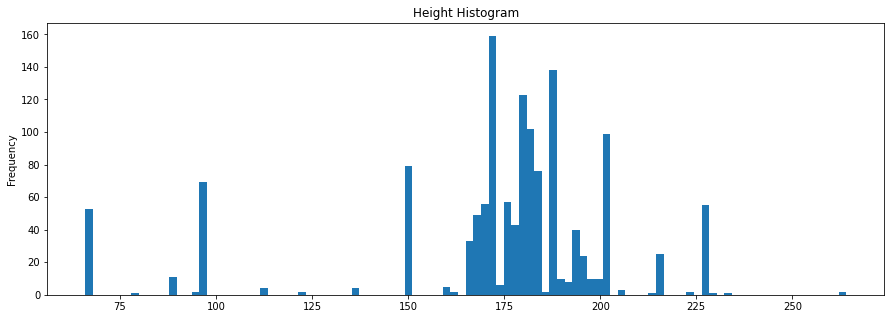

In [8]:
all_data_df.height.plot(kind="hist", bins=100, figsize=(15,5), title="Height Histogram")

<AxesSubplot:title={'center':'Mass Histogram'}, ylabel='Frequency'>

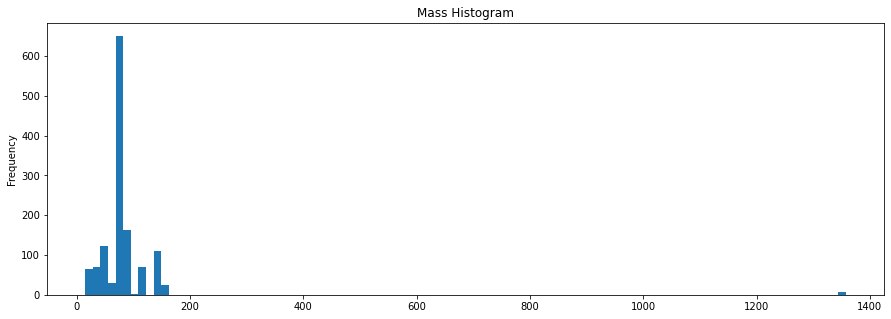

In [9]:
all_data_df.mass.plot(kind="hist", bins=100, figsize=(15,5), title = "Mass Histogram")

<AxesSubplot:title={'center':'Planet Rotation Period Histogram'}, ylabel='Frequency'>

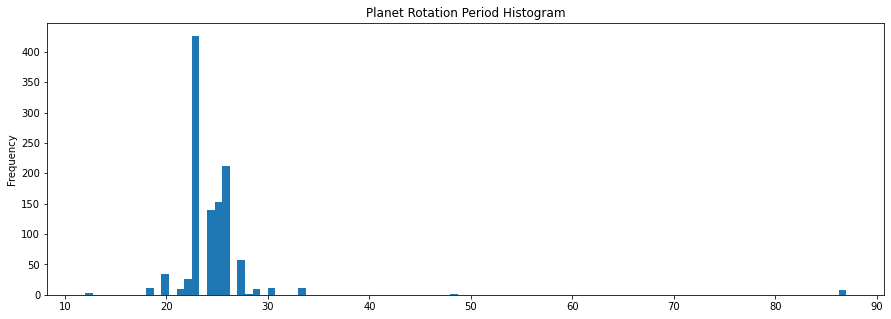

In [10]:
all_data_df.rotation_period.plot(kind="hist", bins=100, figsize=(15,5), title = "Planet Rotation Period Histogram")

<AxesSubplot:title={'center':'Planet Orbital Period Histogram'}, ylabel='Frequency'>

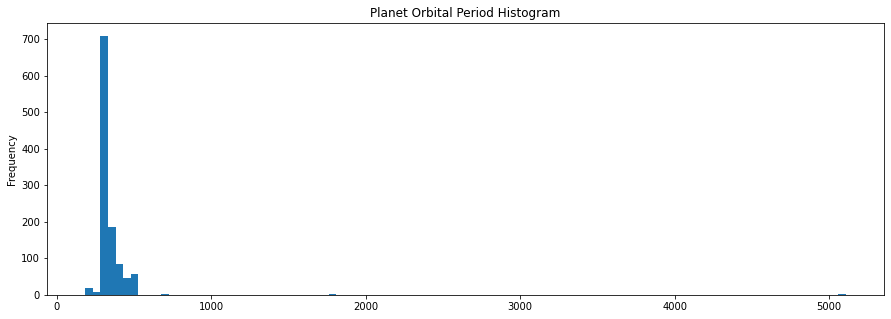

In [11]:
all_data_df.orbital_period.plot(kind="hist", bins=100, figsize=(15,5), title = "Planet Orbital Period Histogram")

<AxesSubplot:title={'center':'Planet Surface Water Histogram'}, ylabel='Frequency'>

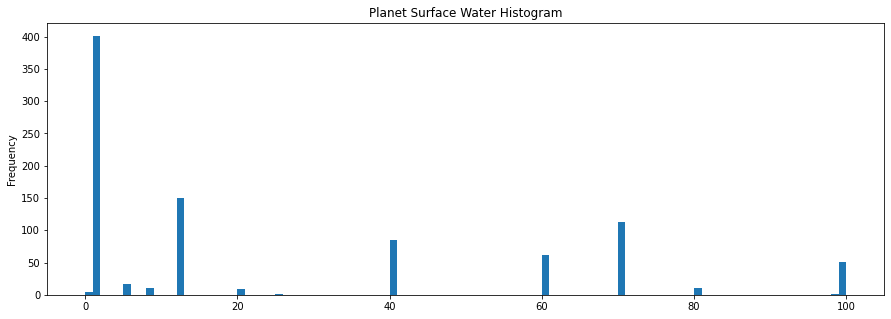

In [12]:
all_data_df.surface_water.plot(kind="hist", bins=100, figsize=(15,5), title = "Planet Surface Water Histogram")

<AxesSubplot:title={'center':'Planet Population Histogram'}, ylabel='Frequency'>

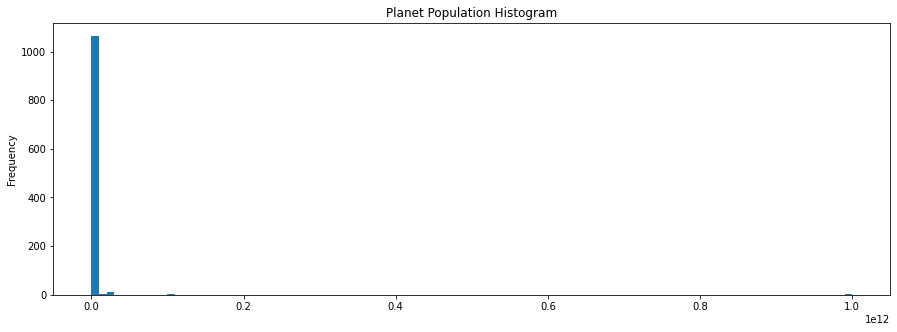

In [13]:
all_data_df.population.plot(kind="hist", bins=100, figsize=(15,5), title = "Planet Population Histogram")

<AxesSubplot:xlabel='height', ylabel='mass'>

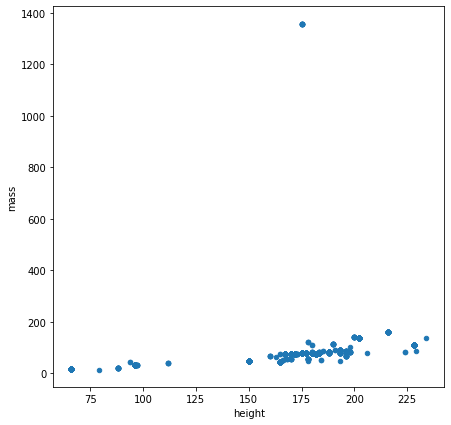

In [14]:
all_data_df.plot(kind='scatter', x='height', y='mass', figsize=(7,7))

<AxesSubplot:xlabel='surface_water', ylabel='population'>

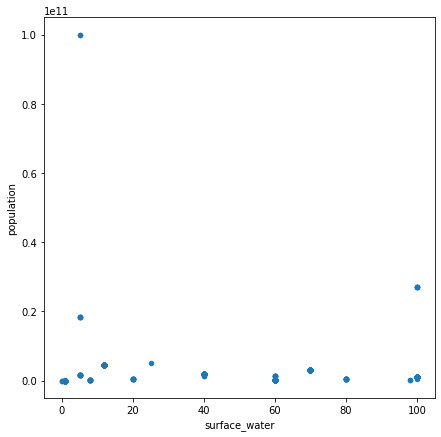

In [15]:
all_data_df.plot(kind='scatter', x='surface_water', y='population', figsize=(7,7))

,Name,Title,Year,Toyline,Brand,height,mass,hair_color,skin_color,eye_color,...,population,classification,designation,average_height,skin_colors,hair_colors,eye_colors,average_lifespan,language,homeworld_species
0,Aayla Secura,Jedi Knight,2005,Revenge Of The Sith Collection,Hasbro,178.0,55.0,none,blue,hazel,...,1.500000e+09,mammals,sentient,200.0,"orange, yellow, blue, green, pink, purple, tan",none,"blue, brown, orange, pink",NaN,Twi'leki,Ryloth
1,Aayla Secura,Revenge Of The Sith,2012,The Vintage Collection,Hasbro,178.0,55.0,none,blue,hazel,...,1.500000e+09,mammals,sentient,200.0,"orange, yellow, blue, green, pink, purple, tan",none,"blue, brown, orange, pink",NaN,Twi'leki,Ryloth
2,Aayla Secura,Includes Flight Gear!,2012,The Clone Wars Collection,Hasbro,178.0,55.0,none,blue,hazel,...,1.500000e+09,mammals,sentient,200.0,"orange, yellow, blue, green, pink, purple, tan",none,"blue, brown, orange, pink",NaN,Twi'leki,Ryloth
3,Aayla Secura,Battle Of Geonosis,2008,Star Wars SAGA Series,Hasbro,178.0,55.0,none,blue,hazel,...,1.500000e+09,mammals,sentient,200.0,"orange, yellow, blue, green, pink, purple, tan",none,"blue, brown, orange, pink",NaN,Twi'leki,Ryloth
4,Aayla Secura,Clone Wars,2010,The Clone Wars Collection,Hasbro,178.0,55.0,none,blue,hazel,...,1.500000e+09,mammals,sentient,200.0,"orange, yellow, blue, green, pink, purple, tan",none,"blue, brown, orange, pink",NaN,Twi'leki,Ryloth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,Yoda,The Jedi Master,1980,Vintage Empire Strikes Back,Kenner,66.0,17.0,white,green,brown,...,NaN,mammal,sentient,66.0,"green, yellow","brown, white","brown, green, yellow",900,Galactic basic,NaN
1442,Yoda,The Jedi Master,1980,Vintage Empire Strikes Back,Kenner,66.0,17.0,white,green,brown,...,NaN,mammal,sentient,66.0,"green, yellow","brown, white","brown, green, yellow",900,Galactic basic,NaN
1443,Zam Wesell,Attack Of The Clones,2011,The Vintage Collection,Hasbro,168.0,55.0,blonde,"fair, green, yellow",yellow,...,NaN,reptilian,sentient,180.0,"green, yellow",none,yellow,70,Clawdite,Zolan
1444,Zam Wesell,Sneak Preview,2002,Power Of The Jedi,Hasbro,168.0,55.0,blonde,"fair, green, yellow",yellow,...,NaN,reptilian,sentient,180.0,"green, yellow",none,yellow,70,Clawdite,Zolan


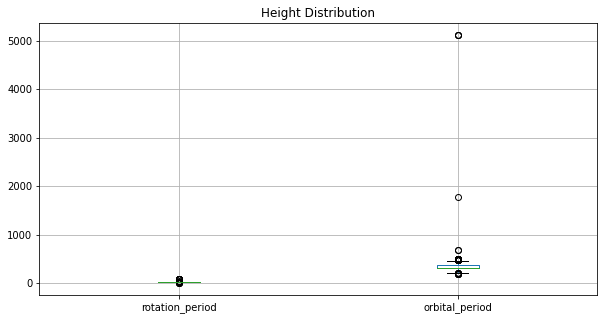

In [42]:
all_data_df[["rotation_period", "orbital_period"]].plot(kind="box", vert=True, grid=True, figsize=(10,5), title="Height Distribution")
all_data_df

# Analysis

#### What characters are most commonly made into action figures? Who is the most popular?

<AxesSubplot:title={'center':'Top 5 Most Popular Characters'}>

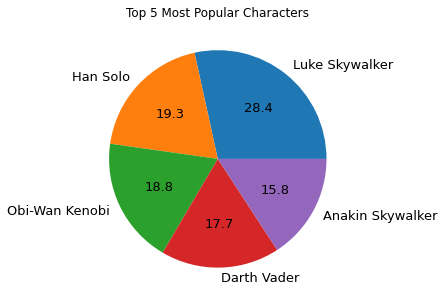

In [17]:
df = all_data_df.groupby("Name").Title.count().sort_values(ascending=False).head()
#df.plot(kind="bar", grid=False, title="Most Popular Characters")
df.plot(kind="pie", grid=False, title="Top 5 Most Popular Characters", ylabel="", figsize=(5,5), autopct='%.1f', fontsize=13)

Taking the five most commonly made characters, the pie chart above shows what percentage of the total five that each character makes up.

#### What types of characters are the most common?

<AxesSubplot:title={'center':'Classifications'}, xlabel='classification'>

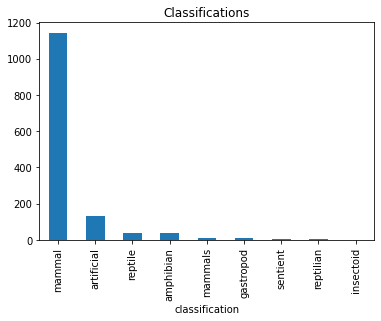

In [18]:
df = all_data_df.groupby("classification").Title.count().sort_values(ascending=False)
df.plot(kind="bar", grid=False, title="Classifications")

The above plot shows the 7 different types of characters in star wars, ordered by most common. We see that mammals are the most popular, though they are also the most prominent in the movies.

#### Which species are the most common?

<AxesSubplot:title={'center':'Most Common Planets'}, xlabel='homeworld_species'>

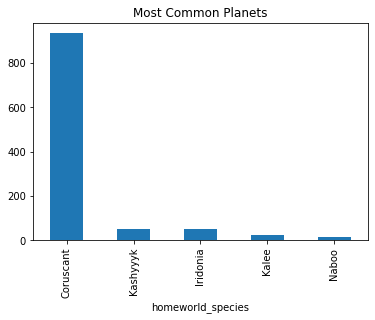

In [19]:
df = all_data_df.groupby("homeworld_species").Title.count().sort_values(ascending=False).head()
df.plot(kind="bar", grid=False, title="Most Common Planets")

#### Which species are the tallest?

<AxesSubplot:title={'center':'Tallest Species'}, xlabel='homeworld_species'>

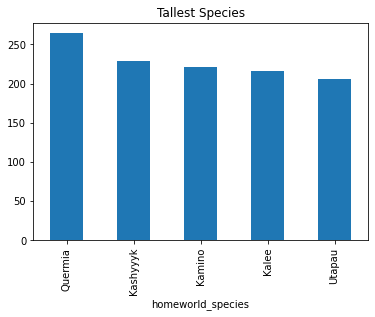

In [20]:
df = all_data_df.groupby("homeworld_species").height.mean().sort_values(ascending=False).head()
df.plot(kind="bar", grid=False, title="Tallest Species")

#### What does famous character production look like over time?

<AxesSubplot:title={'center':'Luke Skywalker Productions over the years'}, xlabel='Year'>

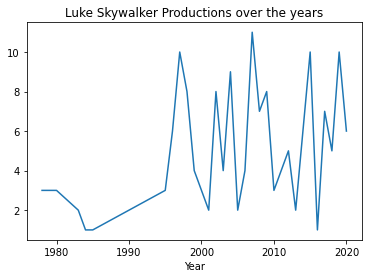

In [21]:
lukedf = all_data_df[all_data_df.Name == "Luke Skywalker"]
df = lukedf.groupby("Year").count().Name
df.plot(kind="line", grid=False, title="Luke Skywalker Productions over the years")

#### What does overall Star Wars figure production look like over time?

<AxesSubplot:title={'center':'Total Number Made per Year'}, xlabel='Year'>

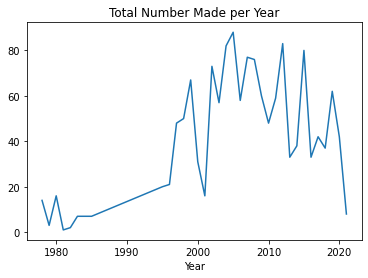

In [22]:
df = all_data_df.groupby("Year").Name.count()
df.plot(kind="line", grid=False, title="Total Number Made per Year")

### View bar plots for eye colors, hair colors, or skin colors

In [23]:
df = all_data_df[['Name', 'eye_color', 'hair_color', 'skin_color']]
df = df.groupby(['Name', 'eye_color', 'hair_color', 'skin_color']).count().reset_index()

In [24]:
# Your answer here
from ipywidgets import widgets, interactive, Layout
w = widgets.ToggleButtons(
    description = 'Physical Characteristics:',
    options = ['Eye Colors', 'Hair Colors', 'Skin Colors'],
    value = 'Eye Colors',
    style = {"description_width": '50px'},
    layout = Layout(width="70%")
)

def view(char):
    if char == "Eye Colors":
        df_tmp = df.groupby("eye_color").Name.count().sort_values(ascending=False)
    if char == "Hair Colors":
        df_tmp = df.groupby("hair_color").Name.count().sort_values(ascending=False)
    if char == "Skin Colors":
        df_tmp = df.groupby("skin_color").Name.count().sort_values(ascending=False)
    
    title = "Type: {}".format(char)
    df_tmp.plot(kind="bar", grid=False, title="Most Common")

i = interactive(view, char=w)  # The value of the widget is passed as a parameter value.
display(i)

interactive(children=(ToggleButtons(description='Physical Characteristics:', layout=Layout(width='70%'), optio…

These are adjusted to not count multiple characters more than once.
i.e. blue eyes bar would be much larger if using raw counts since Luke Skywalker is the most common character.

# Analysis of Toylines

#### What are some trends we can find by looking at the different toylines?

Throughout the history of the Star Wars franchise, there have been several toylines. From the vintage lines during the original trilogy to the Power of the Force in the 1990s to the Vintage Collection in the 2010s and present, several different lines have been released with a different variety of characters. This next section will use the Master List from jedibusiness.com for analysis.

In [25]:
# reading Master List data
masterlist = pd.read_csv("data/JediBusinessFigures.csv")
masterlist

,Name,Title,Year,Toyline,Size,Brand
0,0-0-0,Doctor Aphra Comic Set 3-Pack,2018.0,The Vintage Collection,"3 3/4""",Hasbro
1,2-1B,Medical Droid,2008.0,The 30th Anniversary Collection,"3 3/4""",Hasbro
2,2-1B,Rebel Set 3-Pack,2011.0,The Vintage Collection,"3 3/4""",Hasbro
3,2-1B,Medical Droid,1997.0,The Power Of The Force,"3 3/4""",Hasbro
4,3T-RNE,Star Tours,2005.0,The Disney Collection,"3 3/4""",Hasbro
...,...,...,...,...,...,...
3362,Wicket,Star Wars: Ewoks,1985.0,Vintage Ewoks,"3 3/4""",Kenner
3363,Yak Face,Saelt-Marae,1985.0,Vintage Power Of The Force,"3 3/4""",Kenner
3364,Yoda,The Jedi Master,1980.0,Vintage Empire Strikes Back,"3 3/4""",Kenner
3365,Yoda,The Jedi Master,1980.0,Vintage Empire Strikes Back,"3 3/4""",Kenner


With data on every 3.75" Star Wars action figure ever made, we can now look at some trends. The most interesting column for plotting is Toyline. We can count the number of figures in each line and come up with a bar chart.

<AxesSubplot:title={'center':'Number of Characters by Toyline'}, ylabel='Toyline'>

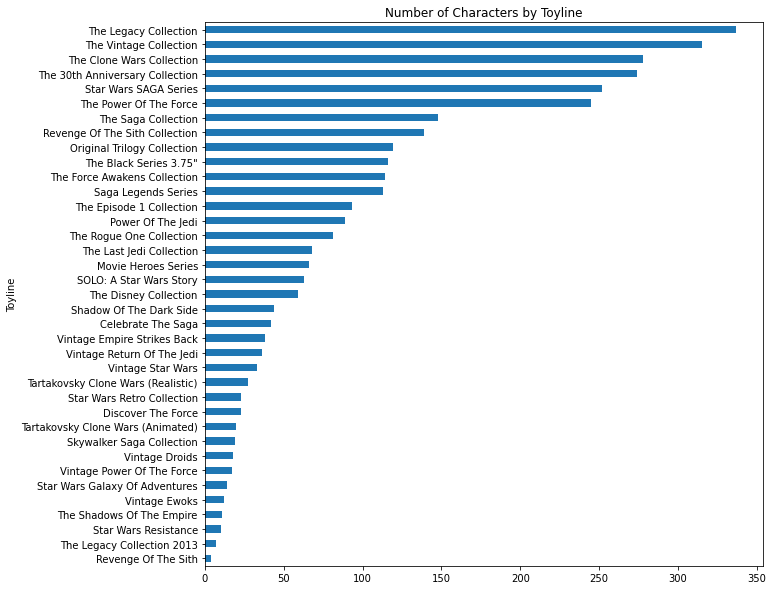

In [26]:
# Counting and plotting number of characters in each toyline
countCharacters = masterlist.groupby("Toyline").Name.count()    
countCharacters.sort_values().plot(kind="barh", title="Number of Characters by Toyline", figsize=(10,10))

These results match up with what a Star Wars action figure collector would expect. The Legacy Collection ran about a decade ago and featured characters from every movie. The Vintage Collection started after the Legacy Collection and also featured characters from every movie. This is the trend we observe. Lines that are not limited to a certain movie and ran for multiple years are at the top. One might think the Clone Wars Collection is an outlier, but this is not surprising due to the amount of characters in the show and how long it ran, from the movie in 2008 to the last season in 2020. At first glance, the lack of figures from Revenge of the Sith is surprisingly low, but this is different from the Revenge of the Sith Collection, which is towards the top. Prequel lines have more figures than Original Trilogy lines due to the known popularity of action figures at the time of release. Our next step is to analyze each toyline individually.

In [27]:
# Letting user choose line and see summary statistics
w_line = widgets.Dropdown(
    description='Toyline:',
    options = ["All"] + sorted(list(set(masterlist.Toyline))),  
    value = "All",
    style = {"description_width": '50px'},
    layout = Layout(width="15%")
)

def view(line):
    if line == "All":
        masterlist_tmp = masterlist
    else:
        masterlist_tmp =masterlist[masterlist.Toyline == line]
        
    masterlist_updated = masterlist_tmp.groupby("Title").Name.count().sort_values()[-5:]

    title = "Top 5 Titles for {}".format(line)
    masterlist_updated.plot(kind="barh", title=title, grid=True, figsize=(15,7))

ActionFigurePlot = interactive(view, line=w_line)
display(ActionFigurePlot)

interactive(children=(Dropdown(description='Toyline:', layout=Layout(width='15%'), options=('All', 'Celebrate …

This widget allows you to look at the most common title by toyline. For example, the 2012 Aayla Secura figure from the Vintage Collection is her design from Revenge of the Sith, so this is the title assigned to that figure. The movies are a common theme among titles in the most popular lines, while lines for only one movie or show tended to have less variety.

In [28]:
countProduction = masterlist.groupby("Name").Name.count().to_frame(name="count")
masterlist_n = pd.merge(masterlist,countProduction,on="Name",how="left")
masterlist_n

,Name,Title,Year,Toyline,Size,Brand,count
0,0-0-0,Doctor Aphra Comic Set 3-Pack,2018.0,The Vintage Collection,"3 3/4""",Hasbro,1
1,2-1B,Medical Droid,2008.0,The 30th Anniversary Collection,"3 3/4""",Hasbro,4
2,2-1B,Rebel Set 3-Pack,2011.0,The Vintage Collection,"3 3/4""",Hasbro,4
3,2-1B,Medical Droid,1997.0,The Power Of The Force,"3 3/4""",Hasbro,4
4,3T-RNE,Star Tours,2005.0,The Disney Collection,"3 3/4""",Hasbro,1
...,...,...,...,...,...,...,...
3362,Wicket,Star Wars: Ewoks,1985.0,Vintage Ewoks,"3 3/4""",Kenner,11
3363,Yak Face,Saelt-Marae,1985.0,Vintage Power Of The Force,"3 3/4""",Kenner,4
3364,Yoda,The Jedi Master,1980.0,Vintage Empire Strikes Back,"3 3/4""",Kenner,53
3365,Yoda,The Jedi Master,1980.0,Vintage Empire Strikes Back,"3 3/4""",Kenner,53


The number of times each character has been produced has been added as a new column. Main characters have been made many times, some obscure characters have only been made once, and several popular background characters have been produced multiple times. An arbitrary count of five variations in one character has been chosen as a target variable.

In [29]:
countProduction = masterlist_n.groupby("Name").Name.count().to_frame(name="count")
nrows = len(countProduction.index)
count5 = masterlist_n.groupby("Name").Name.count()
n = 0
for i in count5:
    if i >=5:
        n=n+1
totalrows = len(masterlist_n.index)
total_5ormore = len(masterlist_n[masterlist_n["count"] > 4].index)
print("{} of {} characters have been produced five or more times, which is {} percent.".
      format(n,nrows,round(n/nrows*100,1)))
print("However, {} of {} ({} of figures) in the master list are characters that have been made five or more times.".
      format(total_5ormore,totalrows,round(total_5ormore/totalrows*100,1)))

122 of 928 characters have been produced five or more times, which is 13.1 percent.
However, 2225 of 3367 (66.1 of figures) in the master list are characters that have been made five or more times.


We can see that only about 13% of characters have been produced in this quantity, so it is an interesting question to look into. Logistic regression will be used to predict if example action figures were produced five or more times.

In [30]:
masterlist_n["FiveOrMore"] = 0
for i in range(len(masterlist_n)-1):
    if masterlist_n["count"][i] >= 5:
        masterlist_n["FiveOrMore"][i] = 1
masterlist_n

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Name,Title,Year,Toyline,Size,Brand,count,FiveOrMore
0,0-0-0,Doctor Aphra Comic Set 3-Pack,2018.0,The Vintage Collection,"3 3/4""",Hasbro,1,0
1,2-1B,Medical Droid,2008.0,The 30th Anniversary Collection,"3 3/4""",Hasbro,4,0
2,2-1B,Rebel Set 3-Pack,2011.0,The Vintage Collection,"3 3/4""",Hasbro,4,0
3,2-1B,Medical Droid,1997.0,The Power Of The Force,"3 3/4""",Hasbro,4,0
4,3T-RNE,Star Tours,2005.0,The Disney Collection,"3 3/4""",Hasbro,1,0
...,...,...,...,...,...,...,...,...
3362,Wicket,Star Wars: Ewoks,1985.0,Vintage Ewoks,"3 3/4""",Kenner,11,1
3363,Yak Face,Saelt-Marae,1985.0,Vintage Power Of The Force,"3 3/4""",Kenner,4,0
3364,Yoda,The Jedi Master,1980.0,Vintage Empire Strikes Back,"3 3/4""",Kenner,53,1
3365,Yoda,The Jedi Master,1980.0,Vintage Empire Strikes Back,"3 3/4""",Kenner,53,1


With the target variable created, we can create the model. Variables will be Year, Toyline, and Brand. Toyline and brand must be manipulated since they are categorical variables.  

In [31]:
lr = LogisticRegression(solver="liblinear")
masterlist_n.Toyline, masterlist_n.Brand = pd.Categorical(masterlist_n.Toyline), pd.Categorical(masterlist_n.Brand)
masterlist_n.Toyline, masterlist_n.Brand = masterlist_n.Toyline.cat.codes, masterlist_n.Brand.cat.codes

masterlist_n = masterlist_n.dropna()
X, y = masterlist_n[["Year","Toyline","Brand"]], masterlist_n["FiveOrMore"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test,y_test)

(0.6668016194331984, 0.6529126213592233)

We would like the model to be more accurate, but this is not too bad considering what we are given. We avoided overfitting and had correct predictions for a majority of rows. However, the accuracy is almost the same as the percentage of figures in the master list who are from characters that have been made five or more times, so the model does not appear to be much better than predicting a success every time.

In [32]:
lr.coef_

array([[ 0.00050859, -0.01714608, -0.00021886]])

This shows that the model does not have any extremely influential coefficients. As figures get made later, it is more likely that the character has been made five or more times. Some of the first toylines alphabetically may also give better chances. The Brand coefficient shows that figures made by Kenner may be less likely to be made five or fewer times, but it is so low that concluding there is no effect is also reasonable. Example predictions are shown in the function below.

In [33]:
def ProductionPredictor(Name, Year, Toyline, Brand):
    prediction = lr.predict([[Year, Toyline, Brand]])
    if (prediction==1):
        return("We predict that this {} action figure was produced five or more times.".format(Name))
    else:
        return("We predict that this {} action figure was produced four or fewer times.".format(Name))
print(ProductionPredictor("Grand Admiral Thrawn", 2022, 30, 0))
print(ProductionPredictor("Ben Quadinaros", 2008, 17, 0))
print(ProductionPredictor("Willrow Hood", 1980, 32, 1))

We predict that this Grand Admiral Thrawn action figure was produced five or more times.
We predict that this Ben Quadinaros action figure was produced five or more times.
We predict that this Willrow Hood action figure was produced five or more times.


These are three hypothetical action figures that are not in the master list. They include a Grand Admiral Thrawn figure that would be released next year in the Vintage Collection, a Ben Quadinaros figure that would have been released in the Saga Collection, and a Willrow Hood figure that would have been released in the Vintage Empire Strikes Back line. The predictions all make sense since the Saga and Vintage collections included characters who have frequently been made and characters from the Empire Strikes Back vintage line have tended to be made several times. Overall, this model is likely not the best way and a better one can be made with different data. The main takeaway is that if you take a given action figure, there is a good chance the character has already been made. Another approach may be better.

## Can we predict how many figures will be made of a character?

With the data we gathered, we wanted to see if we could predict the number of action figures that have been made of a character.

We first chose the columns we wanted to model with from the joined dataset and grouped the data. We had to do two groups and a join to preserve the columns we wanted along with the count of the number of figures.

In [34]:
char_info = all_data_df.groupby('Name')[['Jedi','Sith','Hero','Villain','BountyHunter','Neutral','OriginalTril','PrequelTril','SequelTril','Movies']].mean().reset_index()
figure_count = all_data_df.groupby('Name').Title.count().reset_index()
figure_count.columns = ['Name','Num_Figures']
df_join = char_info.join(figure_count.set_index('Name'), on = 'Name', how='inner')
df_join.sort_values('Num_Figures', ascending=False)

,Name,Jedi,Sith,Hero,Villain,BountyHunter,Neutral,OriginalTril,PrequelTril,SequelTril,Movies,Num_Figures
45,Luke Skywalker,1,0,1,0,0,0,1,0,1,6,153
33,Han Solo,0,0,1,0,0,0,1,0,1,6,104
52,Obi-Wan Kenobi,1,0,1,0,0,0,1,1,0,6,101
23,Darth Vader,0,1,0,1,0,0,1,1,0,5,95
3,Anakin Skywalker,1,0,1,0,0,0,0,1,0,3,85
...,...,...,...,...,...,...,...,...,...,...,...,...
16,Captain Panaka,0,0,1,0,0,0,0,1,0,1,1
69,San Hill,0,0,0,1,0,0,0,1,0,1,1
27,Finis Valorum,0,0,0,0,0,1,0,1,0,1,1
65,Raymus Antilles,0,0,1,0,0,0,1,1,0,2,1


We know there are a lot of characters in our Action Figures dataset that were not included in the much smaller characters dataset, but we wanted to know if there were any characters in our data that have not been made into an action figure. We found that three of our 87 characters in the characters dataset have not been made into an action figure.

In [35]:
characters_full[characters_full.name.isin(df_join.Name) == False]

,name,height,mass,hair_color,skin_color,eye_color,birth_year,gender,homeworld,species,Jedi,Sith,Hero,Villain,BountyHunter,Neutral,OriginalTril,PrequelTril,SequelTril,Movies
57,Cordé,157.0,NaN,brown,light,brown,Unknown,female,Naboo,Human,0,0,0,0,0,1,0,1,0,1
58,Cliegg Lars,183.0,NaN,brown,fair,blue,82BBY,male,Tatooine,Human,0,0,0,0,0,1,0,1,0,1
62,Dormé,165.0,NaN,brown,light,brown,Unknown,female,Naboo,Human,0,0,0,0,0,1,0,1,0,1


Next we needed to define our training and testing sets.

Since our characters dataset was so small and we knew enough characters outside the dataset, we decided to use all of the data we had to create the training set without spliting the data

In [36]:
features = ['Jedi', 'Sith', 'Hero', 'Villain', 'BountyHunter', 'Neutral',
            'OriginalTril', 'PrequelTril', 'SequelTril', 'Movies']
target = 'Num_Figures'

X_train = df_join[features]
y_train = df_join[target]

For the test set, we used our Star Wars knowledge to create a file `AddedCharacters.csv` which included characters to make up our test data that were in our action figures dataset but not in our small characters dataset.

In [37]:
test_df = pd.read_csv('data/AddedCharacters.csv')
figureTotals = actionFigures.groupby('Name').Title.count().reset_index()
figureTotals.columns = ['Name','Num_Figures']
test_df_join = test_df.join(figureTotals.set_index('Name'), on = 'Name', how='inner').reset_index().drop(columns=['index'])
X_test = test_df_join[features]
y_test = test_df_join[target]
test_df_join.head(10)

,Name,Jedi,Sith,Hero,Villain,BountyHunter,Neutral,OriginalTril,PrequelTril,SequelTril,Movies,Num_Figures
0,Coleman Trebor,1,0,1,0,0,0,0,1,0,1,2
1,Clegg Holdfast,0,0,0,0,0,1,0,1,0,1,2
2,Agen Kolar,1,0,1,0,0,0,0,1,0,2,4
3,Mars Guo,0,0,0,0,0,1,0,1,0,1,2
4,Sephjet Josall,1,0,1,0,0,0,0,1,0,1,1
5,Yaddle,1,0,1,0,0,0,0,1,0,1,2
6,Constable Zuvio,0,0,0,0,0,1,0,0,1,1,1
7,Ody Mandrell,0,0,0,0,0,1,0,1,0,1,1
8,Mawhonic,0,0,0,0,0,1,0,1,0,1,2
9,Ask Aak,0,0,0,0,0,1,0,1,0,2,1


### k-Nearest Neighbors Regressor (k = 3)

In [38]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train,y_train)
scores = {'Model':['kNN Regressor'],'Training_Score':[knn.score(X_train,y_train)], 'Testing_Score':[knn.score(X_test,y_test)]}

scores_df = pd.DataFrame(scores)
df_join['predKNN'] = knn.predict(X_train)
test_df_join['predKNN'] = knn.predict(X_test)

print("Train Score: " + str(knn.score(X_train,y_train)))
print("Test Score: " + str(knn.score(X_test,y_test)))

Train Score: 0.7552492985143455
Test Score: 0.17293480806199535


### Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train,y_train)
scores = {'Model':'Linear Regression','Training_Score':lr.score(X_train,y_train), 'Testing_Score':lr.score(X_test,y_test)}

scores_df = scores_df.append(scores, ignore_index = True)
df_join['predLR'] = lr.predict(X_train)
test_df_join['predLR'] = lr.predict(X_test)

print("Train Score: " + str(lr.score(X_train,y_train)))
print("Test Score: " + str(lr.score(X_test,y_test)))

Train Score: 0.6023154258515568
Test Score: -0.07377894003038388


### Decision Tree Regression

In [40]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train)
scores = {'Model':'Decision Tree Regressor','Training_Score':dtr.score(X_train,y_train), 'Testing_Score':dtr.score(X_test,y_test)}

scores_df = scores_df.append(scores, ignore_index = True)
df_join['predDT'] = dtr.predict(X_train)
test_df_join['predDT'] = dtr.predict(X_test)

print("Train Score: " + str(dtr.score(X_train,y_train)))
print("Test Score: " + str(dtr.score(X_test,y_test)))

Train Score: 0.8821211486747319
Test Score: -0.11694880110223416


### Model Evaluation
To see the scores for these models all side by side, we added all the scores to one dataframe `scores_df`. 

We can see here that our training scores are much higher than our testing scores.  This is likely due to the fact that the training and testing sets aren't true random.  All of the main characters were included in the characters dataset from Kaggle, whereas the characters in our test set are more minor background characters that we may not even be referenced by name during the movie.  This meant main of the characters in our training set have been made into action figures many more times than the characters in the test data.

If we had a larger characters dataset to train with in the beginning that would could have split into train/test sets, then we would expect to see some better scores for the test data.

In [41]:
scores_df

,Model,Training_Score,Testing_Score
0,kNN Regressor,0.755249,0.172935
1,Linear Regression,0.602315,-0.073779
2,Decision Tree Regressor,0.882121,-0.116949


### Challenges Throughout the Project
The biggest challenges we faced throughout this project all had to deal with the data we were working with. We didn't realize how few characters were included in the characters dataset. This severely hindered our ability to try to answer our question on what makes a character more likely to be made into an action figure. If we had more data, our machine learning models could have been improved due to more data points to train the models on.  Our limited dataset made it difficult to achieve the goals we were initially looking to reach when we started the project.